In [ ]:

import sys
print(sys.executable)
import platform
print(platform.python_version())

/usr/bin/python3
3.7.11


In [ ]:
# Data handling
import pandas as pd 
import numpy as np

# Clustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

In [ ]:
def load_preprocess_data():
    """ Load and preprocess data
    """
    # load dataset
    df = pd.read_csv('/content/sample_data/data_credit_card_customer_seg.csv')
    
    # handle missing values by replace it by means
    df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
    
    # drop unnecessary column
    df = df.drop(['CUST_ID', 'ONEOFF_PURCHASES','ONEOFF_PURCHASES_FREQUENCY','MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE'], axis=1)
    df= df.round(2)
    return  df

df = load_preprocess_data()
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS
0,40.90,0.82,95.40,95.4,0.00,0.17,0.08,0.00,0,2,1000.0,201.80
1,3202.47,0.91,0.00,0.0,6442.95,0.00,0.00,0.25,4,0,7000.0,4103.03
2,2495.15,1.00,773.17,0.0,0.00,1.00,0.00,0.00,0,12,7500.0,622.07
3,1666.67,0.64,1499.00,0.0,205.79,0.08,0.00,0.08,1,1,7500.0,0.00
4,817.71,1.00,16.00,0.0,0.00,0.08,0.00,0.00,0,1,1200.0,678.33


# **1. Data Normalization**

In [ ]:
# Data Standardization(Z-score Normalization)
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

In [ ]:
scaled_df.shape

(8950, 12)

# **2. Autoencoder**

1. Autoencoder a type of nn to perform data encoding
2. Unsupervised learning with encoding and decoding
3. fit the model with the same input and output
4. Adding a bottle neck in the network
5. Work well for correlated data

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, Sequential

### 2.1 create a model

In [ ]:
# create a model
input_df = Input( shape = (12, ))

x = Dense(7, activation = 'relu')(input_df)

x = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(x)

x = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(x)

x = Dense(2000, activation = 'relu', kernel_initializer='glorot_uniform')(x)

encoded = Dense(10, activation = 'relu', kernel_initializer='glorot_uniform')(x)

x = Dense(2000, activation = 'relu', kernel_initializer='glorot_uniform')(encoded)

x = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(x)

decoded = Dense(12, kernel_initializer='glorot_uniform')(x)

autoencoder = Model(input_df, decoded)

encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

### 2.2 Fit autoencoder

In [ ]:
autoencoder.fit(scaled_df,scaled_df, batch_size= 120, epochs = 30, verbose = 1)

Epoch 1/30
75/75 [==============================] - 3s 44ms/step - loss: 0.0344
Epoch 2/30
75/75 [==============================] - 3s 43ms/step - loss: 0.0325
Epoch 3/30
75/75 [==============================] - 3s 43ms/step - loss: 0.0333
Epoch 4/30
75/75 [==============================] - 3s 43ms/step - loss: 0.0304
Epoch 5/30
75/75 [==============================] - 3s 44ms/step - loss: 0.0283
Epoch 6/30
75/75 [==============================] - 3s 43ms/step - loss: 0.0285
Epoch 7/30
75/75 [==============================] - 3s 44ms/step - loss: 0.0303
Epoch 8/30
75/75 [==============================] - 3s 44ms/step - loss: 0.0248
Epoch 9/30
75/75 [==============================] - 3s 44ms/step - loss: 0.0239
Epoch 10/30
75/75 [==============================] - 3s 44ms/step - loss: 0.0217
Epoch 11/30
75/75 [==============================] - 3s 44ms/step - loss: 0.0221
Epoch 12/30
75/75 [==============================] - 3s 43ms/step - loss: 0.0214
Epoch 13/30
75/75 [==================

In [ ]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 91        
_________________________________________________________________
dense_9 (Dense)              (None, 500)               4000      
_________________________________________________________________
dense_10 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_11 (Dense)             (None, 2000)              1002000   
_________________________________________________________________
dense_12 (Dense)             (None, 10)                20010     
_________________________________________________________________
dense_13 (Dense)             (None, 2000)              2200

### 2.3 Feature compression

In [ ]:
pred = encoder.predict(scaled_df)
pred.shape

(8950, 10)

# **3. Kmeans with encoded data**

### 3.1 Find the optimal cluster number & compare score1 and score2

In [ ]:
score_2 = []
range_values = range(1, 20)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(pred)
    score_2.append(kmeans.inertia_)
  
plt.plot(score_2, 'bx-', color = 'b', label = 'Compressed Data')
plt.legend()

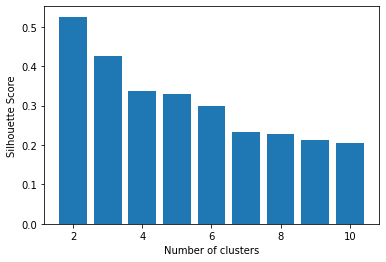

In [ ]:
# silhouette score
silhouette_scores = []

for n_cluster in range(2, 11):
    silhouette_scores.append(silhouette_score(pred, KMeans(n_clusters = n_cluster).fit_predict(pred))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6, 7,8,9,10] 

plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

Highest silhouette score is k = 2

## **K=4**

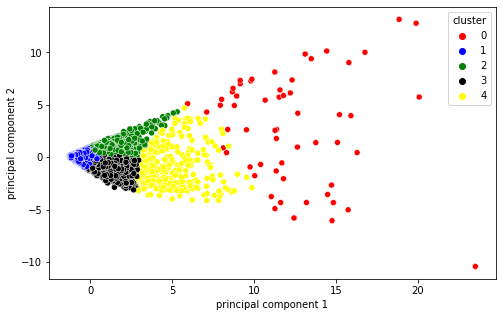

In [ ]:
# Kmeans algorithm
kmean= KMeans(n_clusters=5,init='k-means++')
kmean.fit(pred)
labels=kmean.labels_


# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pred)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

# scatterplot
plt.figure(figsize=(8,5))
ax = sns.scatterplot( data=finalDf,x="principal component 1", y="principal component 2", hue="cluster",palette=['red','blue','green','black','yellow'])
plt.show()

In [ ]:
df.head()

,BALANCE,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS
0,40.90,95.40,95.4,0.00,1000.0,201.80
1,3202.47,0.00,0.0,6442.95,7000.0,4103.03
2,2495.15,773.17,0.0,0.00,7500.0,622.07
3,1666.67,1499.00,0.0,205.79,7500.0,0.00
4,817.71,16.00,0.0,0.00,1200.0,678.33


1    6420
3    1184
2     936
4     351
0      59
Name: cluster, dtype: int64


Text(0.5, 0, 'SEGMENTS')

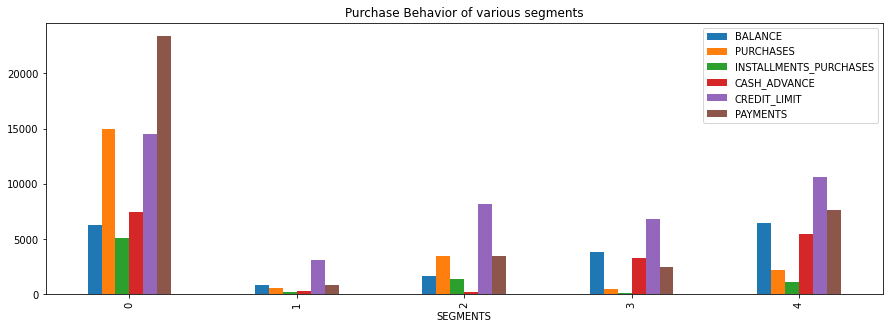

In [ ]:
# Cluster feature visualization
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
print(clusters['cluster'].value_counts())
(clusters[['BALANCE', 'PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 
            'cluster']]
 .groupby('cluster').mean().plot.bar(figsize=(15, 5)))
plt.title('Purchase Behavior of various segments')
plt.xlabel('SEGMENTS')

### Conclusion


* **Cluster 0 :**This customer group indicates a small group of customers who have medium balances, spenders (high purchase) with the highest payment and cross their credit limit (100+)

* **Cluster 1 :** This customer group indicates a small group of customers who have high balances and cash advances, low purchase frequency with low credit limit. We can assume that this customer segment uses their credit cards as a loan. (2000+)

* **Cluster 2 :** This customer group indicates a small group of customers who have medium balances, spenders (high purchase) with the highest credit limit.
(1000+)

* **Cluster 3 :** This customer group indicates a large group of customers who have low balances, low purchase frequency and high payment frequency.(5000+)

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

clusters.head()

,BALANCE,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,cluster
0,40.90,95.40,95.4,0.00,1000.0,201.80,1
1,3202.47,0.00,0.0,6442.95,7000.0,4103.03,3
2,2495.15,773.17,0.0,0.00,7500.0,622.07,1
3,1666.67,1499.00,0.0,205.79,7500.0,0.00,1
4,817.71,16.00,0.0,0.00,1200.0,678.33,1


In [ ]:
# Putting feature variable to X
X = clusters.drop(['cluster'], axis=1)
X.round({"BALANCE":2, "PURCHASES":2, "INSTALLMENTS_PURCHASES":2, "CASH_ADVANCE":2,"CREDIT_LIMIT":2,"PAYMENTS":2})

X.head()

,BALANCE,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS
0,40.90,95.40,95.4,0.00,1000.0,201.80
1,3202.47,0.00,0.0,6442.95,7000.0,4103.03
2,2495.15,773.17,0.0,0.00,7500.0,622.07
3,1666.67,1499.00,0.0,205.79,7500.0,0.00
4,817.71,16.00,0.0,0.00,1200.0,678.33


In [ ]:
y = clusters['cluster']
y.head()

0    1
1    3
2    1
3    1
4    1
Name: cluster, dtype: int32

In [ ]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
clf=KNeighborsClassifier(n_neighbors=4)
clf.fit(X_train, y_train)
accuracy=clf.score(X_train, y_train)
print(accuracy)

0.9710893854748603


In [ ]:
example = np.array([[40.900749,95.40,95.0,0.000000,1000.0,201.802084]])
prediction=clf.predict(example)
print(prediction)

[1]


In [ ]:
prob=clf.predict_proba(example)
print(prob)

[[0. 1. 0. 0. 0.]]


In [ ]:
# Here, we will save the 'lr' model to disk as 'model.py'

import pickle

pickle.dump(clf,open('ModelTwo.pkl','wb'))
# Dump this model by the name "model.py" in the systems HDD and while doing this
# write this file using "write bytes" mode.